# Chat Bots with LSTMs

This notebook implements a Question-Answer bot which is able to answer questions given a base story. The [BaBi](https://research.facebook.com/downloads/babi/) dataset from Facebook/Meta is used. This dataset is composed with examples consisting of three elemets (Story-Question-Answer), as the following:

```
1. Story: Jane went to the store. Mike ran to the bedroom.
2. Question: Is Mike in the store?
3. Answer: No
```

The built model follows paper by Sukhbaatar et al., linked in the course:

`../literature/SukhbaatarFergus_EndToEndMemoryNetworks_2015.pdf`

**Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, and Rob Fergus. End-To-End Memory Networks, 2015.**

Note that the implementaton of the model is specific to the model!

Overview of contents:
1. End-To-End Memory Networks, by Sukhbaatar et al., 2015
    - Approach
    - Model & Training Details
    - Simplified Example in the Notebook
2. Load and Prepare the Dataset
    - 2.1 Understand the Structure of the Dataset
    - 2.2 Set Up the Vocabulary
    - 2.3 Vectorize the Dataset
    - 2.4 Functionalize the Vectorization
3. Model
    - 3.1 Encoders
        - Embedding A / Input Encoder m: `x_i -> m_i`
        - Embedding C / Input Encoder c: `x_i -> c_i`
        - Embedding B / Input Encoder u: `q -> u`
        - Encode the Sequences: `m_i`, `c_i`, `u`
    - 3.2 Apply the Encoders and Get Outputs
        - Match Probability:  `p_i <- softmax(u^T m_i)`
        - Response/Output Vector `o`
        - Concatenate: `o + u`
    - 3.3 Finalize Model Layers
    - 3.4 Training
4. Evaluation
5. Inference with New Texts: Writing Our Own Stories

*Diclaimer: I made this notebook while following the Udemy course [NLP - Natural Language Processing with Python](https://www.udemy.com/course/nlp-natural-language-processing-with-python/) by José Marcial Portilla. The original course notebooks and materials were provided with a download link, I haven't found a repository to fork from.*

## 1. End-To-End Memory Networks, by Sukhbaatar et al., 2015

Answering questions given context is very challenging, because long-term dependencies need to be addressed in sequential data.

Appreaches that use **attention** an **explicit storage** have appeared to solve tackle the problem.

The papper presents a RNN in which the recurrence reads from an external memory in multiple hops or computational steps per searched symbol.

### Approach

The model

- takes
    - a discrete set of inputs that are store in the memory: `x1, x2, ..., xn`
    - a query `q`
- outputs: an answer `a`

Each of the `x`, `a`, `q` contains symbols that com from a vocabulary/dictionary with `V` words. I understand that `x` is a collection of sequences, while `q` and `a` are supposed to be one sequence each.

The model writes all `x` to the memory up to a fixed buffer size and then finds a continuous representation for the `x` and `q` (using embeddings). Then, those continuous representations are processed in several steps/hops to obtain `a`.

Each layer has the following components:
- The input memory where all sentences/sequences `x` and `q` are stored encoded in an embedding A.
- The ouput memory where all sentences/sequences `x` are stored encoded in an embedding C; this memory contains the seed elements that, together with `q`, lead to an answer `a`.
- The generator of the final prediction of the layer, which combines the items in both.

Then, these single layers are combined as recurrent layers that perform several hops or steps to obtain the final output.

A single layer consists of the following operations, and it is depicted in the figure below:

- given `x_i`, we compute in th einput memory: `m_i <- EmbeddingA(x_i)`
- we store the vector `m_i` in the input memory
- given `q`, we compute: `u <- EmbeddingB(q)`
- we store the vector `u` in the input memory
- we computethe match weight/probability `p_i` as: `p_i = softmax(u^T * m_i)` (inner product)
- given `x_i`, we compute in the output memory: `c_i <- EmbeddingC(x_i)`
- the output/response vector `o` is the sum of `c_i` weighted by `p_i`: `o <- sum(p_i*c_i)`
- the predicted answer `a` is: `a <- softmax(W(o+u))`
    - `W` is a weight matrix of size `V x d`
    - `V`: number of symbols/tokens in the vocabulary/dictionary
    - `d`: size of the compact sequence vectors in the embedding
    
Note that everything is differentiable. That makes possible to use backpropagation, i.e., we can train the layers to optimize the weights of `W`.

![End-To-End memory Networks](../pics/end_to_end_memory_networks.png)

The recurrent aspect is achieved by stacking one layer after the other. All layers get all sentences of the story `x` and the same question `q`, but the output from the previous layer is summed to the question in the next layer.

### Model & Training Details

- `K = 3` hops/steps or layers were used.
- Tyically, the answr is a single words, but sometimes several.
- Some sentences in the story are irrelevant for the answer; the relevant ones are called **support** and the model detects them.
- The sentences are represented initially as bags of words; each sentence `x_i` in a story is transformed in `m_i` by summing all the vector representations of all words after applying the embedding.
- In order to preserve the order aspect of the words in a sentence and the temporal aspect of the sentences in a story, some weights/encoding are applied element-wise to the summations.
- They found that adding random noise to the temporal encoding improved the performance.
- Learning rate: `lr = 0.01`, annealing to `lr/2` every 25 epochs until 100 epochs were reached.
- The `null` symbol was used for padding.

### Simplified Example in the Notebook

The example in this notebook uses a very similar approach, but the dataset consists of Story-Question-Answer items that have only `Yes/No` answers.

## 2. Load and Prepare the Dataset

In [46]:
import pickle
import numpy as np

In [47]:
# Watch out: the TXT is a binary, thus we need to use pickle to read it
with open("../data/train_qa.txt", "rb") as fp:   # Unpickling
    train_data =  pickle.load(fp)

In [48]:
# Watch out: the TXT is a binary, thus we need to use pickle to read it
with open("../data/test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

### 2.1 Understand the Structure of the Dataset

In [49]:
type(train_data)

list

In [51]:
# 10,000 items for the training data
len(train_data)

10000

In [52]:
# Pick and display one item: Story, Question, Answer.
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [53]:
# Print the Story
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [54]:
# Print the Question
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [59]:
# Print the Answer: IT IS ALWAYS YES/NO!
train_data[0][2]

'no'

### 2.2 Set Up the Vocabulary

In [62]:
# Create a set that holds the vocab words
# Set: unordered collection of unique items
vocab = set()

In [61]:
# Concatenate both splits
all_data = test_data + train_data

In [64]:
for story, question , answer in all_data:
    # In case you don't know what a union of sets is:
    # https://www.programiz.com/python-programming/methods/set/union
    # Basically, a union is done: all distinct items are taken to create a new set.
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [65]:
# Since the Answer is always Yes/No, we add these words manually
vocab.add('no')
vocab.add('yes')

In [67]:
# Display all possible vocabulary words.
# Note that they are not that much.
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [116]:
vocab_len = len(vocab) + 1 # we add an extra space to hold a 0 for Keras's pad_sequences

In [118]:
vocab_len

38

In [69]:
# How long is the longest Story?
max_story_len = max([len(data[0]) for data in all_data])

In [23]:
max_story_len

156

In [70]:
# How long is the longest Question?
max_question_len = max([len(data[1]) for data in all_data])

In [71]:
max_question_len

6

### 2.3 Vectorize the Dataset

In [26]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [72]:
# Integer encoded sequences of words
# We don't need to use any filters with our dataset
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [73]:
# Dictionary/Map of word->index
tokenizer.word_index

{'apple': 1,
 'no': 2,
 '?': 3,
 'yes': 4,
 'bathroom': 5,
 'grabbed': 6,
 'down': 7,
 '.': 8,
 'hallway': 9,
 'bedroom': 10,
 'kitchen': 11,
 'dropped': 12,
 'is': 13,
 'mary': 14,
 'picked': 15,
 'daniel': 16,
 'garden': 17,
 'left': 18,
 'there': 19,
 'moved': 20,
 'to': 21,
 'office': 22,
 'sandra': 23,
 'milk': 24,
 'discarded': 25,
 'journeyed': 26,
 'in': 27,
 'back': 28,
 'up': 29,
 'john': 30,
 'got': 31,
 'took': 32,
 'football': 33,
 'went': 34,
 'travelled': 35,
 'the': 36,
 'put': 37}

In [75]:
# Unpack Story/Question/Answer to lists
train_story_text = []
train_question_text = []
train_answers = []
for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [85]:
# Convert text/string sequences to integer sequences
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [86]:
train_story_text[0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [87]:
train_story_seq[0]

[14, 20, 21, 36, 5, 8, 23, 26, 21, 36, 10, 8]

In [88]:
len(train_story_text)

10000

In [89]:
len(train_story_seq)

10000

### 2.4 Functionalize the Vectorization

In the following, we create a function that creates valid input vectors of a dataset. Basically, S-Q-A texts are converted into integer/word-index matrices. Note that the answers are allowed to have the same dimension as the size of the vocabulary (`+1`, because of Keras convention). I understand that the logic is the following: originally, an answer of a single word was allowed, no matter which word in the vocabulary; thus, the answer is a dummy/one-hot endoded vectors. In the present simplified implementation, that same architecture/design is used, but through the dataset and its training, only the words `yes`/`no` appear in the answers. Thus, I could easily modify this example to get any single word as answer (one word from the vocabulary) -- only, I would require a valid dataset with any single word as answer.

In [126]:
def vectorize_stories(data,
                      word_index=tokenizer.word_index,
                      max_story_len=max_story_len,
                      max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories, Queries, and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)

    OUTPUT:
    
    Vectorizes the stories, questions, and answers into padded sequences.
    We first loop for every story, query, and answer in the data.
    Then we convert the raw words to an word index value.
    Then we append each set to their appropriate output list.
    Then, once we have converted the words to numbers,
    we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X, Xq, Y) (padded based on max lengths)
    '''
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER (yes/no)
    Y = []
    
    # For each Story-Question-Answer
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        # We create an array of size the number of vocabulary items
        #y = np.zeros(len(word_index) + 1)
        y = np.zeros(vocab_len)
        
        # Now that y is all zeros and we know it's just Yes/No,
        # we can use numpy logic to create this assignment
        # Everything is 0 except the answer word (yes/no)
        # Why? In understand that originally the answer is supposed to be one word
        # not just yes/no. Thus, here the architecture/structure is maintained,
        # but the model is trained only with yes/no.
        y[word_index[answer]] = 1
        
        # Append each set of story, query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),
            pad_sequences(Xq, maxlen=max_question_len),
            np.array(Y))

In [127]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [128]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [129]:
# Number of S-Q-A items x max_story_len (maximum number of words in a story)
inputs_test.shape

(1000, 156)

In [130]:
inputs_test

array([[ 0,  0,  0, ..., 36, 10,  8],
       [ 0,  0,  0, ..., 36, 17,  8],
       [ 0,  0,  0, ..., 36, 17,  8],
       ...,
       [ 0,  0,  0, ..., 36,  1,  8],
       [ 0,  0,  0, ..., 36, 17,  8],
       [ 0,  0,  0, ...,  1, 19,  8]], dtype=int32)

In [131]:
# Number of S-Q-A items x max_question_len (maximum number of words in a story)
queries_test.shape

(1000, 6)

In [132]:
queries_test

array([[13, 30, 27, 36, 11,  3],
       [13, 30, 27, 36, 11,  3],
       [13, 30, 27, 36, 17,  3],
       ...,
       [13, 14, 27, 36, 10,  3],
       [13, 23, 27, 36, 17,  3],
       [13, 14, 27, 36, 17,  3]], dtype=int32)

In [133]:
# Number of S-Q-A items x (vocabulary length + 1)
answers_test.shape

(1000, 38)

In [134]:
answers_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [135]:
# All answers must be yes (index 4) or no (index 2)
# Thus, the sum must be concentrated in those two elements/indices
sum(answers_test)

array([  0.,   0., 503.,   0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [136]:
tokenizer.word_index['yes']

4

In [137]:
tokenizer.word_index['no']

2

## 3. Model

In this section, the DL model that predicts answers given a story and a question is built. The model is strongly based on the one suggested in the paper by Sukhbaatar et al. referenced above. Read the paper or the notes to understand the architecture.

In [124]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [125]:
# Input() is used to instantiate Keras tensors
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

### 3.1 Encoders

#### Embedding A / Input Encoder m: `x_i -> m_i`

In [139]:
# vocab_len
vocab_size = len(vocab) + 1

In [149]:
# Input gets embedded to a sequence of vectors
# This encoder will output:
# (samples, story_maxlen, embedding_dim)
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
# We add a dropout of 30% to prevent overfitting
input_encoder_m.add(Dropout(0.3))

#### Embedding C / Input Encoder c: `x_i -> c_i`

In [151]:
# Embed the input into a sequence of vectors of size query_maxlen
# Output: (samples, story_maxlen, max_question_len)
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

#### Embedding B / Input Encoder u: `q -> u`

In [152]:
# Embed the question into a sequence of vectors
# Output: (samples, query_maxlen, embedding_dim)
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

#### Encode the Sequences: `m_i`, `c_i`, `u`

In [171]:
# Encode input sequence and questions (which are indices)
# to sequences of dense vectors.
# We basically apply the encoers/embeddings defined until now (above).
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

### 3.2 Apply the Encoders and Get Outputs

#### Match Probability:  `p_i <- softmax(u^T m_i)`

In [155]:
# Dot-product between u and m_i
# Shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

#### Response/Output Vector `o`

In [173]:
# Add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, max_question_len)
# Switch 2 dimensions
response = Permute((2, 1))(response)  # (samples, max_question_len, story_maxlen)

#### Concatenate: `o + u`

Why concatenate? I though we add them. That's what seems to be written in the paper, too...?

In [174]:
# Concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [175]:
# Shape: ?, 6, 220
answer

<tf.Tensor 'concatenate_3/concat:0' shape=(None, 6, 220) dtype=float32>

### 3.3 Finalize Model Layers

I don't understand why he does this. where are the `K=3` hops?

In [176]:
# Reduce with RNN (LSTM) ???
answer = LSTM(32)(answer)  # (samples, 32)

In [177]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
# Although only yes/no is expected expected (because the training dataset has only yes/no)
# we allow the probabilities to be associated t o each of the words in the vocabulary
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [178]:
# We output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# Build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [179]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
                                                                 input_2[0][0]              

### 3.4 Training

In [181]:
# We should train for at least 120 epochs!
history = model.fit([inputs_train, queries_train],
                    answers_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 12s 1ms/step - loss: 0.2699 - accuracy: 0.8797 - val_loss: 0.3637 - val_accuracy: 0.8370
Epoch 2/10
10000/10000 [==============================] - 13s 1ms/step - loss: 0.2742 - accuracy: 0.8787 - val_loss: 0.3786 - val_accuracy: 0.8250
Epoch 3/10
10000/10000 [==============================] - 15s 2ms/step - loss: 0.2752 - accuracy: 0.8792 - val_loss: 0.3613 - val_accuracy: 0.8350
Epoch 4/10
10000/10000 [==============================] - 11s 1ms/step - loss: 0.2717 - accuracy: 0.8794 - val_loss: 0.3704 - val_accuracy: 0.8340
Epoch 5/10
10000/10000 [==============================] - 11s 1ms/step - loss: 0.2689 - accuracy: 0.8830 - val_loss: 0.3643 - val_accuracy: 0.8360
Epoch 6/10
10000/10000 [==============================] - 11s 1ms/step - loss: 0.2668 - accuracy: 0.8835 - val_loss: 0.3588 - val_accuracy: 0.8390
Epoch 7/10
10000/10000 [==============================] - 11s 1ms/ste

In [182]:
# Save the model
filename = 'chatbot_60_epochs.h5'
model.save(filename)

## 4. Evaluation

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


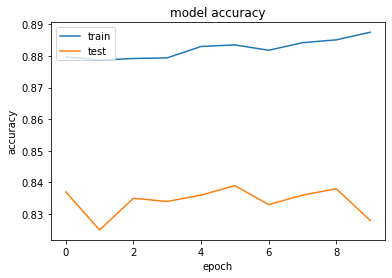

In [187]:
# Accuracy plotting
# Note that the plot below is maybe not accurate, since I would need to let it train longer
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [200]:
# Instead of using our trained model
# we load the weights of a moddel provvided in teh course
#filename = 'chatbot_120_epochs.h5'
filename = 'chatbot_60_epochs.h5'
model.load_weights(filename)
# And predict the answers of the test split
pred_results = model.predict(([inputs_test, queries_test]))

In [201]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [202]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [203]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [204]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [206]:
# Generate prediction from model
# In my case it seems to perform poorly - it is not even able to provide just yes/no
# BUT that is maybe because the tokenizer is different now...
# With my trained model it seems to work...
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.99932635


## 5. Inference with New Texts: Writing Our Own Stories

We can write our own stories, but always using the words in the vocabulary!

In [207]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [208]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [209]:
my_question = "Is the football in the garden ?"

In [210]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [211]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [212]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [213]:
pred_results = model.predict(([ my_story, my_ques]))

In [214]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.99961543
